In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import uniform

# Implementation of a generator for α-stable distribution and estimators of α parameter

Method `alpha_stable_gen(alpha, beta, gamma, delta, n)` generetes α-stable distribution.


$Z \sim S(\alpha, \beta; 1)$:

$$
Z = 
 \begin{cases}
   \frac{\sin {\alpha (\theta_o + \Theta)}}
        {(\cos{\alpha \theta_0} \cos{\Theta})^{1 / \alpha}} 
        \left[ \frac{\cos{(\alpha \theta_0 + (\alpha - 1) \Theta)}}
        {W} \right]^{(1-\alpha)\alpha}, 
        & \alpha \neq 1\\
   \frac{2}{\pi} \left[ (\frac{\pi}{2} + \beta \Theta) \tan{\Theta} - \beta \log{\left( 
     \frac{\frac{\pi}{2} W \cos{\Theta}}
     {\frac{\pi}{2} + \beta \Theta}\right)
   }\right],
        & \alpha = 1
 \end{cases}
$$

> where 

> $\Theta$ and $W$ - independent;

> $\Theta$ uniformly distributed on $\left(-\frac{\pi}{2}, \frac{\pi}{2} \right)$; 

> $W$ exponentially distributed with mean 1;

> $0 < \alpha \leqslant 2$;

> $-1 \leqslant \beta \leqslant 1$;

> $\theta_0 = \arctan{(\beta \tan({\pi \alpha / 2)}) / \alpha}$ when $\alpha \neq 1$.

Then $X \sim S(\alpha, \beta, \gamma, \delta; 1)$:

$$
X = 
 \begin{cases}
   \gamma Z + \delta, 
        & \alpha \neq 1\\
   \gamma Z + \delta + \beta \frac{2}{\pi} \gamma \log{\gamma},
        & \alpha = 1
 \end{cases}
$$














In [8]:
def alpha_stable_gen(alpha, beta, gamma, delta, n):
  """
  Function to generate independent alpha stable random variables

  params
  ------
  alpha - stability parameter (float)
  beta - skewness parameter (float)
  gamma - scale parameter (float)
  delta- location parameter (float)
  n - number of simulated independent random variables (int)

  returns
  -------
  array of length n of independent alpha stable random variables (np.array)
  """

  Theta = np.random.uniform(-np.pi/2, np.pi/2, n)
  W = np.random.exponential(1, n)
  theta_0 = np.arctan(beta * np.tan(np.pi * alpha/2))/alpha
  if alpha != 1:
      Z = np.sin(alpha * (theta_0 + Theta))/(np.cos(alpha * theta_0) * np.cos(Theta))**(1/alpha) * (np.cos(alpha * theta_0 + (alpha - 1) * Theta) / W)**((1-alpha) / alpha)
      X = gamma * Z + delta
  else:
      Z = 2/np.pi * ((np.pi/2 + beta * Theta) * np.tan(Theta) - beta * np.log((np.pi/2 * W * np.cos(Theta)) / (np.pi/2 + beta * Theta)))
      X = gamma * Z + delta + beta * 2/np.pi * gamma * np.log(gamma)
  return X

Method `alpha_estimation_ecdf(Z)` estimate parameter α based on the ECDF.

We calculate ECDF by the formula:

$$
F(x) = \mathbb{E}[\mathbf{1}_{Z \leqslant x}]
$$

We use only 10% of the values for the estamation.

$1 - F(x) \sim e^c x^{-\alpha}$

So $\log{(1 - F(x))} \sim - \alpha \log{x} + c$.

$x = \log{x}, \;\;\; y = \log{(1 - F(x))}, \;\;\; a = -\alpha, \;\;\; b = c$

Calculate the coefficients of the linear regression $y = ax + b$ by the formulas:

$a = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$

$b = \bar{y} - a \bar{x}$

In [9]:
def alpha_estimation_ecdf(Z):
  """
  Function to estimate alpha parameter of the stable random variables 
  based on empirical cumulative distribution function

  params
  ------
  Z - sample of indedependet alpha stable random variables (np.array)

  returns
  -------
  a, b (float, float) - linear regression coefficients, where a = - alpha 
  """

  n = len(Z)
  x_range = np.linspace(0.01, np.max(Z), n)

  ecdf = np.array([np.mean(Z <= x_value) for x_value in x_range])

  n_cut = int(n * 0.1)

  x = x_range[:n_cut]
  x = np.log(x)

  y = (1 - ecdf)[:n_cut]
  y = np.log(y)

  mu_x = np.mean(x)
  mu_y = np.mean(y)
  a = np.sum((x-mu_x) * (y-mu_y)) / np.sum((x - mu_x)**2)
  b = mu_y - a * mu_x
  
  return a, b

Method `alpha_estimation_cf(Z, K)` estimate parameter α based on the CF.

We calculate CF by the formula:

$$
\varphi(t) = \mathbb{E}[e^{itZ}]
$$

We use $t = \pi k / 25, \;\;\; k = 1, \ldots K$.

$|\varphi(t)|^2 = e^{-2c |t|^{\alpha}}$

So $\log({-\log{|\varphi(t)|^2}}) = \alpha \log{|t|} + log{(2c)}$.

$x = \log{t}, \;\;\; y = \log({-\log{|\varphi(t)|^2}}), \;\;\; a = \alpha, \;\;\; b = log{(2c)}$

Calculate the coefficients of the linear regression $y = ax + b$ by the formulas:

$a = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$

$b = \bar{y} - a \bar{x}$

In [10]:
def alpha_estimation_cf(Z, K):
  """
  Function to estimate alpha parameter of the stable random variables
  based on empirical characteristic function

  params
  ------
  Z - sample of indedependet alpha stable random variables (np.array)
  K - 

  returns
  -------
  a, b (float, float) - linear regression coefficients, where a = alpha 
  """  

  n = len(Z)

  t = [np.pi * k / 25 for k in np.linspace(1, K+1, K)]
  cf = [np.mean(np.exp(1j * t_value * Z)) for t_value in t]

  x = np.log(t)
  y = np.log(-np.log(np.abs(cf)**2))

  mu_x = np.mean(x)
  mu_y = np.mean(y)

  a = np.sum((x - mu_x) * (y-mu_y)) / np.sum((x - mu_x)**2)
  b = mu_y - a * mu_x

  return a, b

# A plot of ECDF / CF with the fitted line of the appropriate form

## A generation of α-stable distributions

Consider a set of parameters $(\alpha, \beta, \gamma, \delta) = (0.5, 0.5, 1, 0)$ and generate the α-stable distribution.

In [11]:
alpha = 0.5
beta = 0.5
gamma = 1
delta = 0

n1 = 10000
Z1 = alpha_stable_gen(alpha, beta, gamma, delta, n1)

n2 = 1000
Z2 = alpha_stable_gen(alpha, beta, gamma, delta, n2)

n3 = 500
Z3 = alpha_stable_gen(alpha, beta, gamma, delta, n3)

## A plot of ECDF

Estimate α parameter based on the ECDF. Draw a plot of ECDF with the fitted line of the appropriate form.

In [ ]:
a1, b1 = alpha_estimation_ecdf(Z1)
a2, b2 = alpha_estimation_ecdf(Z2)
a3, b3 = alpha_estimation_ecdf(Z3)

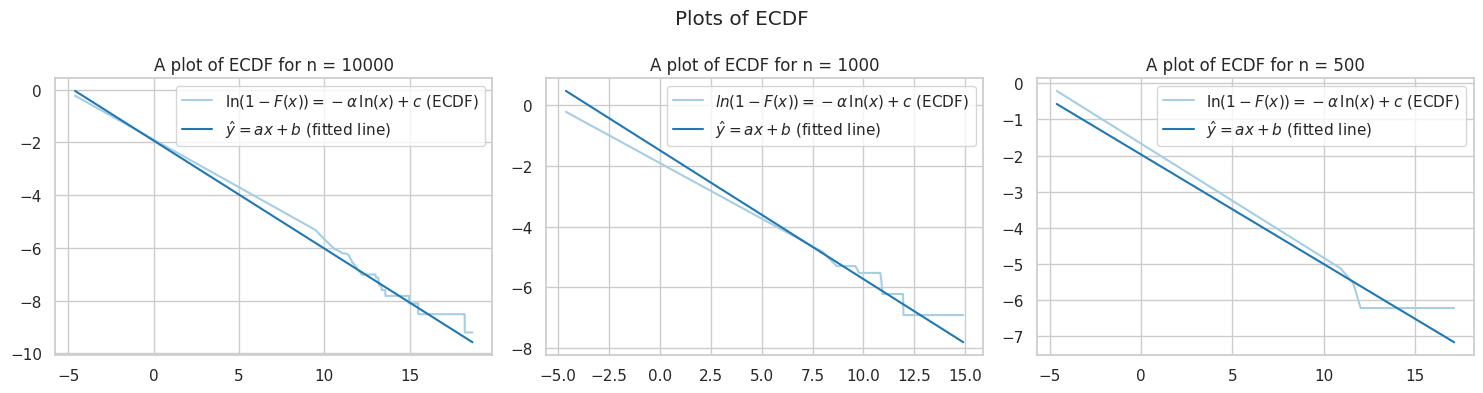

In [ ]:
x1 = np.linspace(0.01, np.max(Z1), n1)
ecdf1 = np.array([np.mean(Z1 <= x_value) for x_value in x1])

x2 = np.linspace(0.01, np.max(Z2), n2)
ecdf2 = np.array([np.mean(Z2 <= x_value) for x_value in x2])

x3 = np.linspace(0.01, np.max(Z3), n3)
ecdf3 = np.array([np.mean(Z3 <= x_value) for x_value in x3])

fig, axs = plt.subplots(1, 3, figsize = (15, 4))
fig.suptitle('Plots of ECDF')

axs[0].plot(np.log(x1[:-1]), np.log(1 - ecdf1[:-1]), label = r"$\ln(1 - F(x)) = -\alpha\,\ln(x) + c$ (ECDF)")
axs[0].plot(np.log(x1), a1 * np.log(x1) + b1, label = r"$\hat y = ax + b$ (fitted line)")
axs[0].set_title(f'A plot of ECDF for n = {n1}')
axs[0].legend()

axs[1].plot(np.log(x2[:-1]), np.log(1 - ecdf2[:-1]), label = r"$ln(1 - F(x)) = -\alpha\,\ln(x) + c$ (ECDF)")
axs[1].plot(np.log(x2), a2 * np.log(x2) + b2, label = r"$\hat y = ax + b$ (fitted line)")
axs[1].set_title(f'A plot of ECDF for n = {n2}')
axs[1].legend()

axs[2].plot(np.log(x3[:-1]), np.log(1 - ecdf3[:-1]), label = r"$\ln(1 - F(x)) = -\alpha\,\ln(x) + c$ (ECDF)")
axs[2].plot(np.log(x3), a3 * np.log(x3) + b3, label = r"$\hat y = ax + b$ (fitted line)")
axs[2].set_title(f'A plot of ECDF for n = {n3}')
axs[2].legend()

fig.tight_layout()
plt.show()

## A plot of CF

Estimate α parameter based on the CF. Draw a plot of CF with the fitted line of the appropriate form.

In [ ]:
K = 10

a1, b1 = alpha_estimation_cf(Z1, K)
a2, b2 = alpha_estimation_cf(Z2, K)
a3, b3 = alpha_estimation_cf(Z3, K)

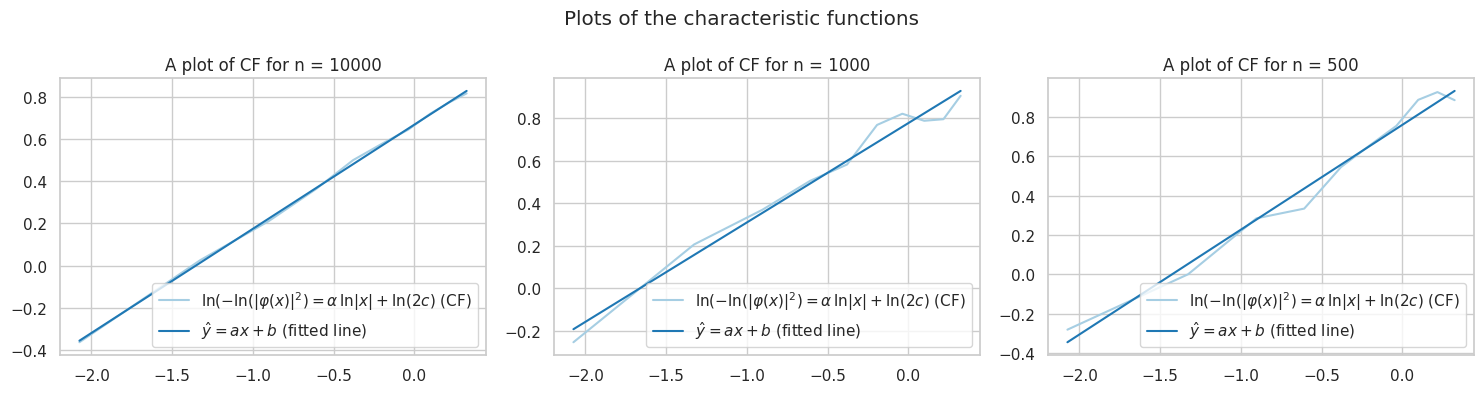

In [ ]:
t = [np.pi * k / 25 for k in np.linspace(1, K+1, K)]

cf1 = [np.mean(np.exp(1j * t_value * Z1)) for t_value in t]
cf2 = [np.mean(np.exp(1j * t_value * Z2)) for t_value in t]
cf3 = [np.mean(np.exp(1j * t_value * Z3)) for t_value in t]

fig, axs = plt.subplots(1, 3, figsize = (15, 4))
fig.suptitle('Plots of the characteristic functions')

axs[0].plot(np.log(t), np.log(-np.log(np.abs(cf1)**2)), label = r"$\ln(-\ln(|\varphi(x)|^2) = \alpha\,\ln|x| + \ln(2c)$ (CF)")
axs[0].plot(np.log(t), a1 * np.log(t) + b1, label = r"$\hat y = ax + b$ (fitted line)")
axs[0].set_title(f'A plot of CF for n = {n1}')
axs[0].legend()

axs[1].plot(np.log(t), np.log(-np.log(np.abs(cf2)**2)), label = r"$\ln(-\ln(|\varphi(x)|^2) = \alpha\,\ln|x| + \ln(2c)$ (CF)")
axs[1].plot(np.log(t), a2 * np.log(t) + b2, label = r"$\hat y = ax + b$ (fitted line)")
axs[1].set_title(f'A plot of CF for n = {n2}')
axs[1].legend()

axs[2].plot(np.log(t), np.log(-np.log(np.abs(cf3)**2)), label = r"$\ln(-\ln(|\varphi(x)|^2) = \alpha\,\ln|x| + \ln(2c)$ (CF)")
axs[2].plot(np.log(t), a3 * np.log(t) + b3, label = r"$\hat y = ax + b$ (fitted line)")
axs[2].set_title(f'A plot of CF for n = {n3}')
axs[2].legend()

fig.tight_layout()
plt.show()

## Conclusion

The plots of characteristic functions look better than the plots for the ECDF (fitted lines are closer to the original lines). 

The methods work well for different n, but results may be slightly worse for smaller n for CF, because the original lines are not so linear.

# Distribution of estimated $\hat{\alpha}$'s from each method (based on Monte Carlo simulations)

## A generation of α-stable distributions, ECDF and CF

In [ ]:
def save_alphas(Z_list, method, file_name):
  """ 
  Function to estimate alpha parameters of the stable random variables
  and save the results to the csv file

  params
  ------
  Z_list - the list of samples of stable random variables (list)
  method - method of estimation ("ecdf" or "cf")
  file_name - the name of csv file (str)
  """

  if method == "ecdf":
      alphas = [-alpha_estimation_ecdf(Z)[0] for Z in Z_list]
  elif method == "cf":
      alphas = [alpha_estimation_cf(Z, K)[0] for Z in Z_list]

  alphas_df = pd.DataFrame(alphas)    
  alphas_df.to_csv(file_name) 

In [14]:
def download_data(file_name):
  """
  Function to dowload saved data

  params
  ------
  file_name - the name of csv file (str)

  returns
  -------
  the array of alphas (np.array)
  """

  df = pd.read_csv(file_name, index_col = 0)
  return df.to_numpy()

In [ ]:
MC = 1000
K = 10
for n in [500, 1000, 10000]:
  for method in ["cf","ecdf"]:
      Z_vec = [alpha_stable_gen(alpha, beta, gamma, delta, n) for _ in range(MC)]
      save_alphas(Z_vec, method, f"alphas_{method}{n}.csv")

In [ ]:
path = "alphas/"
alphas_ecdf10000 = download_data(path + "alphas_ecdf10000.csv")
alphas_ecdf1000 = download_data(path + "alphas_ecdf1000.csv")
alphas_ecdf500 = download_data(path + "alphas_ecdf500.csv")

alphas_cf10000 = download_data(path + "alphas_cf10000.csv")
alphas_cf1000 = download_data(path + "alphas_cf1000.csv")
alphas_cf500 = download_data(path + "alphas_cf500.csv")

## The histograms of ECDF and CF for the different n

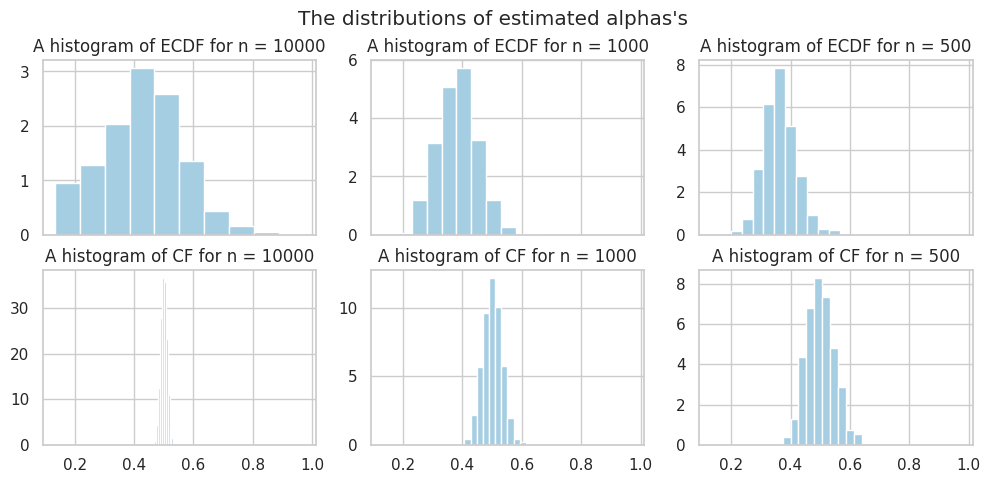

In [ ]:
fig, axs = plt.subplots(2, 3, figsize = (12, 5), sharex = True)
fig.suptitle("The distributions of estimated alphas's")

axs[0, 0].hist(alphas_ecdf10000, density = True)
axs[0, 0].set_title(f'A histogram of ECDF for n = {n1}')

axs[0, 1].hist(alphas_ecdf1000, density = True)
axs[0, 1].set_title(f'A histogram of ECDF for n = {n2}')

axs[0, 2].hist(alphas_ecdf500, density = True)
axs[0, 2].set_title(f'A histogram of ECDF for n = {n3}')

axs[1, 0].hist(alphas_cf10000, density = True)
axs[1, 0].set_title(f'A histogram of CF for n = {n1}')

axs[1, 1].hist(alphas_cf1000, density = True)
axs[1, 1].set_title(f'A histogram of CF for n = {n2}')

axs[1, 2].hist(alphas_cf500, density = True)
axs[1, 2].set_title(f'A histogram of CF for n = {n3}')

plt.show()

In [ ]:
for i, alphas in enumerate([alphas_ecdf10000, alphas_ecdf1000, alphas_ecdf500, alphas_cf10000, alphas_cf1000, alphas_cf500]):
  if i == 0:
    print("ECDF method:")
  elif i == 3:
    print("CF method:")

  if i % 3 == 0: 
    n = 10000
  elif i % 3 == 1: 
    n = 1000
  elif i % 3 == 2: 
    n = 500

  print(f"n: {n}, \t mean: {np.round(np.mean(alphas), 4)}, \t variance: {np.round(np.var(alphas), 3)}, \t median: {np.round(np.median(alphas), 3)}")

ECDF method:
n: 10000, 	 mean: 0.4273, 	 variance: 0.019, 	 median: 0.434
n: 1000, 	 mean: 0.3843, 	 variance: 0.005, 	 median: 0.385
n: 500, 	 mean: 0.3642, 	 variance: 0.003, 	 median: 0.361
CF method:
n: 10000, 	 mean: 0.4998, 	 variance: 0.0, 	 median: 0.5
n: 1000, 	 mean: 0.5001, 	 variance: 0.001, 	 median: 0.499
n: 500, 	 mean: 0.5002, 	 variance: 0.002, 	 median: 0.498


## Conclusion 
On the histograms above it can be seen that for both methods the distribution is symmetric. However for the method based on the characteristic fuction the variance is lower and mean is closer to the theoretical alpha. Hence the characterictic function method is better then the one based on the ecdf since the estimator is unbiased and with lower variance.

The smaller n, the further the mean is from the theoretical alpha (this is not so noticeable for the method based on the characteristic function). In addition, the smaller n, the smaller variance for the method based on the empirical cumulative distribution function, and the larger one for the method based on the characteristic function.

## The boxplots of ECDF and CF for the different n

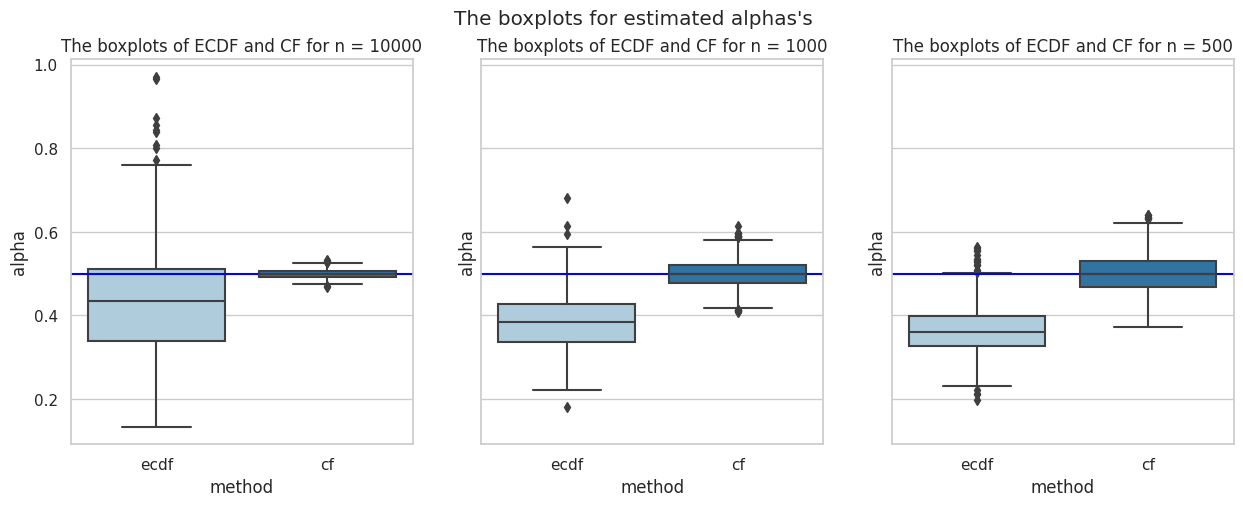

In [ ]:
alphas_df10000 = pd.DataFrame({"ecdf": alphas_ecdf10000.T[0], "cf": alphas_cf10000.T[0]})
alphas_df1000 = pd.DataFrame({"ecdf": alphas_ecdf1000.T[0], "cf": alphas_cf1000.T[0]})
alphas_df500 = pd.DataFrame({"ecdf": alphas_ecdf500.T[0], "cf": alphas_cf500.T[0]})

fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
fig.suptitle("The boxplots for estimated alphas's")
sns.set_theme(style = "whitegrid", palette = "Paired")

sns.boxplot(ax = axes[0], x = "variable", y = "value", data = pd.melt(alphas_df10000))
axes[0].set(xlabel = 'method', ylabel = 'alpha')
axes[0].set_title(f"The boxplots of ECDF and CF for n = {n1}")
axes[0].axhline(alpha, color = (0, 0, 1))

sns.boxplot(ax = axes[1], x = "variable", y = "value", data = pd.melt(alphas_df1000))
axes[1].set(xlabel = 'method', ylabel = 'alpha')
axes[1].set_title(f"The boxplots of ECDF and CF for n = {n2}")
axes[1].axhline(alpha, color = (0, 0, 1))

sns.boxplot(ax = axes[2], x = "variable", y = "value", data = pd.melt(alphas_df500))
axes[2].set(xlabel = 'method', ylabel = 'alpha')
axes[2].set_title(f"The boxplots of ECDF and CF for n = {n3}")
axes[2].axhline(alpha, color = (0, 0, 1))

plt.show()

## Conclusion 
The boxplots above confirm the conclusions drawn on the basis of histograms. The estimator based on the characteristic function method has lower volatility (lower interquartile range) and has median closer to the theoretical alpha. It can be also observed that the characteristic function method performs better for longer samples, while the ecdf method doesn't give satisfying results even for $n$ equal to 10 000.

# Calculate MSE and MAE (mean square errors, mean absolute errors) of the estimators

## MSE and MAE for ECDF for the different n

### ECDF method:

In [ ]:
mse1 = np.mean((alpha - alphas_ecdf10000)**2)
mse2 = np.mean((alpha - alphas_ecdf1000)**2)
mse3 = np.mean((alpha - alphas_ecdf500)**2)

mae1 = np.mean(np.abs(alpha - alphas_ecdf10000))
mae2 = np.mean(np.abs(alpha - alphas_ecdf1000))
mae3 = np.mean(np.abs(alpha - alphas_ecdf500))

print(f"n = {n1}, \t MSE: {mse1}, \t MAE: {mae1}")
print(f"n = {n2}, \t MSE: {mse2}, \t MAE: {mae2}")
print(f"n = {n3}, \t MSE: {mse3}, \t MAE: {mae3}")

n = 10000, 	 MSE: 0.024035293875361272, 	 MAE: 0.12163359214764533
n = 1000, 	 MSE: 0.017958924611517102, 	 MAE: 0.11848015263638989
n = 500, 	 MSE: 0.021484276320794214, 	 MAE: 0.1367301251400881


## CF method

In [ ]:
mse1 = np.mean((alpha - alphas_cf10000)**2)
mse2 = np.mean((alpha - alphas_cf1000)**2)
mse3 = np.mean((alpha - alphas_cf500)**2)

mae1 = np.mean(np.abs(alpha - alphas_cf10000))
mae2 = np.mean(np.abs(alpha - alphas_cf1000))
mae3 = np.mean(np.abs(alpha - alphas_cf500))

print(f"n = {n1}, \t MSE: {mse1}, \t MAE: {mae1}")
print(f"n = {n2}, \t MSE: {mse2}, \t MAE: {mae2}")
print(f"n = {n3}, \t MSE: {mse3}, \t MAE: {mae3}")

n = 10000, 	 MSE: 0.00010496501654840179, 	 MAE: 0.008158536370045528
n = 1000, 	 MSE: 0.0010402486468185151, 	 MAE: 0.025826596634332993
n = 500, 	 MSE: 0.002176888785488697, 	 MAE: 0.03740812188061478


## Conclusion 
Both mean squared error and mean absolute error are smaller for the characteristic function method once again confirming the advantage of this method over the method based on ECDF. There are no major differences between different sample lengths. However, the errors are smaller for longer samples for the characteristic function method.

# Present a two-dimensional contourplot

In [5]:
def paremeter_dependence_mse(param1, param2, other_params, n, method, file_names):
  """ 
  Function to calculate mse depending on the parameters 
  and save the results to the csv files

  params
  ------
  param1 - the list of the first parmeter (list or np.array)
  param2 - the list of the second parmeter (list or np.array)
  other params - the values of parameters which remain constant (tuple)
  n - lengh of the sample used to estimate alpha parameter
  method - which parameters are going to change:
          * "alpha_beta" - first changing parameter is alpha, second - beta
          * "gamma_delta" - first chnaging parameter is gamma, second - delta
  file_names - the names of csv files - first ecdf, then cf (str,str)

  returns
  --------
  two csv files with the mse for different parameters (first parameter - rows, secod - columns)
  """

  K = 10
  n1 = len(param1)
  n2 = len(param2)

  cf_mse = np.zeros((n1, n2))
  ecdf_mse = np.zeros((n1, n2))

  for i, p1 in enumerate(param1):
    for j, p2 in enumerate(param2):
      
      if method == "alpha_beta":
        gamma, delta = other_params
        alpha = p1
        Z_list = [alpha_stable_gen(p1, p2, gamma, delta, n) for _ in range(MC)]
      elif method == "gamma_delta":
        alpha, beta = other_params
        Z_list = [alpha_stable_gen(alpha, beta, p1, p2, n) for _ in range(MC)]

      # alphas_ecdf = np.array([-alpha_estimation_ecdf(Z)[0] for Z in Z_list])
      alphas_cf = np.array([alpha_estimation_cf(Z, K)[0] for Z in Z_list])

      # ecdf_mse[i, j] = np.mean((alpha - alphas_ecdf)**2)
      cf_mse[i, j] = np.mean((alpha - alphas_cf)**2)

  # ecdf_mse_df = pd.DataFrame(ecdf_mse)
  cf_mse_df = pd.DataFrame(cf_mse)

  # ecdf_mse_df.to_csv(file_names[0])
  cf_mse_df.to_csv(file_names[1])

## A two-dimensional contourplot depending on α and β

In [6]:
h = 0.2
alpha_min = h
alpha_max = 2
beta_min = -1 + h
beta_max = 1 + h
alpha_num = int((alpha_max - alpha_min) / h)
beta_num = int((beta_max - beta_min) / h)

MC = 1000

In [12]:
alphas = np.arange(alpha_min, alpha_max, h)
betas = np.arange(beta_min, beta_max, h)

for n in [500, 1000, 10000]:
  paremeter_dependence_mse(alphas, betas, (gamma, delta), n, "alpha_beta", [f"ecdf_mse_ab_{n}.csv", f"cf_mse_ab_{n}.csv"])

In [15]:
path = "alpha_beta/"
ecdf_mse_ab10000 = download_data(path + "ecdf_mse_ab_10000.csv")
ecdf_mse_ab1000 = download_data(path + "ecdf_mse_ab_1000.csv")
ecdf_mse_ab500 = download_data(path + "ecdf_mse_ab_500.csv")
 
cf_mse_ab10000 = download_data(path + "cf_mse_ab_10000.csv")
cf_mse_ab1000 = download_data(path + "cf_mse_ab_1000.csv")
cf_mse_ab500 = download_data(path + "cf_mse_ab_500.csv")

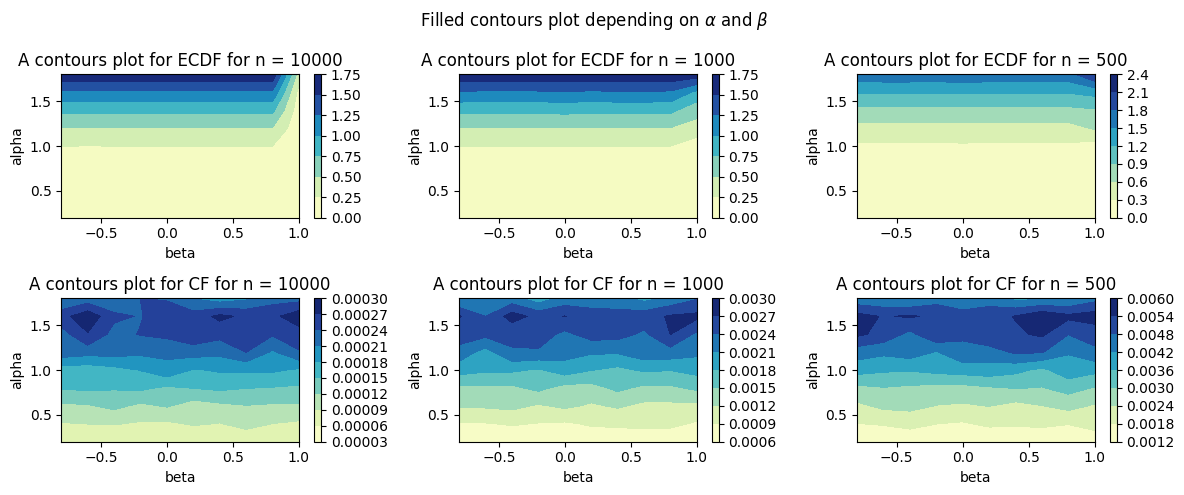

					 for ECDF 		 for CF
Maximum value of MSE for n = 10000: 	 1.6924891782223173 	 0.0002912498410076
Maximum value of MSE for n = 1000: 	 1.7017898627096832 	 0.0028346972946788
Maximum value of MSE for n = 500: 	 2.1074262031705207 	 0.0058827165063622


In [17]:
ylist = np.linspace(alpha_min, alpha_max - h, alpha_num)
xlist = np.linspace(beta_min, beta_max - h, beta_num)
X, Y = np.meshgrid(xlist, ylist)

fig, axs = plt.subplots(2, 3, figsize = (12, 5))
fig.suptitle(r'Filled contours plot depending on $\alpha$ and $\beta$')

cp00 = axs[0, 0].contourf(X, Y, ecdf_mse_ab10000, cmap = 'YlGnBu')
fig.colorbar(cp00)
axs[0, 0].set_xlabel('beta')
axs[0, 0].set_ylabel('alpha')
axs[0, 0].set_title(f'A contours plot for ECDF for n = {n1}')

cp01 = axs[0, 1].contourf(X, Y, ecdf_mse_ab1000, cmap = 'YlGnBu')
fig.colorbar(cp01)
axs[0, 1].set_xlabel('beta')
axs[0, 1].set_ylabel('alpha')
axs[0, 1].set_title(f'A contours plot for ECDF for n = {n2}')

cp02 = axs[0, 2].contourf(X, Y, ecdf_mse_ab500, cmap = 'YlGnBu')
fig.colorbar(cp02)
axs[0, 2].set_xlabel('beta')
axs[0, 2].set_ylabel('alpha')
axs[0, 2].set_title(f'A contours plot for ECDF for n = {n3}')

cp10 = axs[1, 0].contourf(X, Y, cf_mse_ab10000, cmap = 'YlGnBu')
fig.colorbar(cp10)
axs[1, 0].set_xlabel('beta')
axs[1, 0].set_ylabel('alpha')
axs[1, 0].set_title(f'A contours plot for CF for n = {n1}')

cp11 = axs[1, 1].contourf(X, Y, cf_mse_ab1000, cmap = 'YlGnBu')
fig.colorbar(cp11)
axs[1, 1].set_xlabel('beta')
axs[1, 1].set_ylabel('alpha')
axs[1, 1].set_title(f'A contours plot for CF for n = {n2}')

cp12 = axs[1, 2].contourf(X, Y, cf_mse_ab500, cmap = 'YlGnBu')
fig.colorbar(cp12)
axs[1, 2].set_xlabel('beta')
axs[1, 2].set_ylabel('alpha')
axs[1, 2].set_title(f'A contours plot for CF for n = {n3}')

fig.tight_layout()
plt.show()

print("\t\t\t\t\t for ECDF \t\t for CF")
print(f"Maximum value of MSE for n = 10000: \t {ecdf_mse_ab10000.max()} \t {cf_mse_ab10000.max()}")
print(f"Maximum value of MSE for n = 1000: \t {ecdf_mse_ab1000.max()} \t {cf_mse_ab1000.max()}")
print(f"Maximum value of MSE for n = 500: \t {ecdf_mse_ab500.max()} \t {cf_mse_ab500.max()}")

## Conclusion

Mean squared errors are smaller for the method based on the characteristic function confirming the advantage of this method over the method based on ECDF. 

For the method based on the empirical cumulative distribution function: the larger α, the larger mean square error, so the worse results. Additionally, the errors are smaller for longer samples.

For the method based on the characteristic function, we can notice that: the smaller α, the smaller mean square error, so the better results. Additionally, the errors are smaller for longer samples.

# Present a two-dimensional contourplot depending on γ and δ for MSE

In [ ]:
gammas = [0.5, 1, 5, 10]
deltas = [-5, -1, 0, 1, 5]

MC = 1000
K = 10

In [ ]:
for n in [500, 1000, 10000]:
  paremeter_dependence_mse(gammas, deltas, (alpha, beta), n, "gamma_delta", [f"ecdf_mse_gd_{n}.csv", f"cf_mse_gd_{n}.csv"])

In [ ]:
path = "gamma_delta/"
ecdf_mse_gd10000 = download_data(path + "ecdf_mse_gd_10000.csv")
ecdf_mse_gd1000 = download_data(path + "ecdf_mse_gd_1000.csv")
ecdf_mse_gd500 = download_data(path + "ecdf_mse_gd_500.csv")
 
cf_mse_gd10000 = download_data(path + "cf_mse_gd_10000.csv")
cf_mse_gd1000 = download_data(path + "cf_mse_gd_1000.csv")
cf_mse_gd500 = download_data(path + "cf_mse_gd_500.csv")

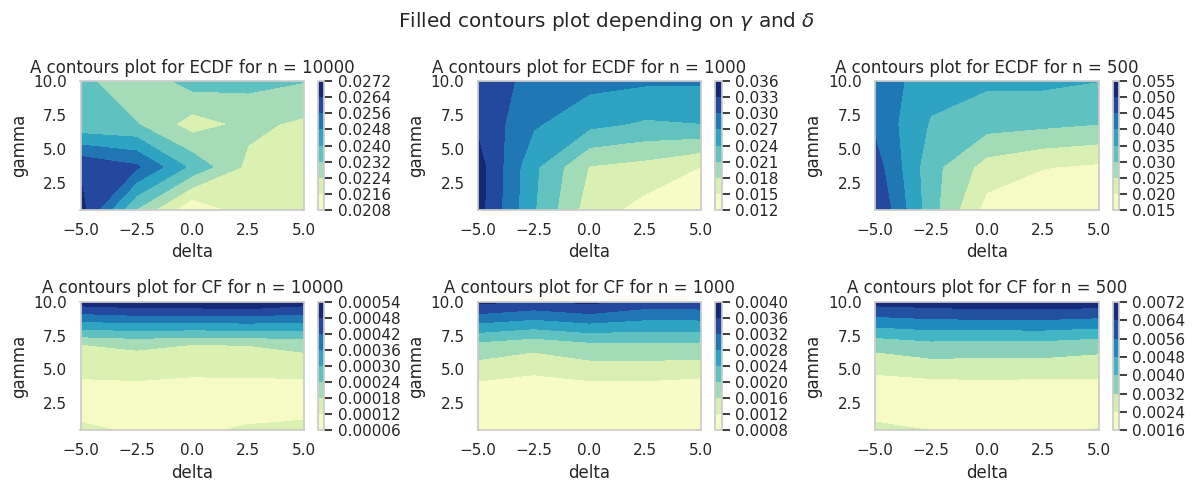

					 for ECDF 		 for CF
Maximum valuse of MSE for n = 10000: 	 0.0267295373146441 	 0.0005363606273091
Maximum valuse of MSE for n = 1000: 	 0.0343754589255 	 0.0037054269312146
Maximum valuse of MSE for n = 500: 	 0.0500540612121641 	 0.0069411638206106


In [ ]:
ylist = np.linspace(gammas[0], gammas[-1], len(gammas))
xlist = np.linspace(deltas[0], deltas[-1], len(deltas))
X, Y = np.meshgrid(xlist, ylist)

fig, axs = plt.subplots(2, 3, figsize = (12, 5))
fig.suptitle(r'Filled contours plot depending on $\gamma$ and $\delta$')

cp00 = axs[0, 0].contourf(X, Y, ecdf_mse_gd10000, cmap = 'YlGnBu')
fig.colorbar(cp00)
axs[0, 0].set_xlabel('delta')
axs[0, 0].set_ylabel('gamma')
axs[0, 0].set_title(f'A contours plot for ECDF for n = {n1}')

cp01 = axs[0, 1].contourf(X, Y, ecdf_mse_gd1000, cmap = 'YlGnBu')
fig.colorbar(cp01)
axs[0, 1].set_xlabel('delta')
axs[0, 1].set_ylabel('gamma')
axs[0, 1].set_title(f'A contours plot for ECDF for n = {n2}')

cp02 = axs[0, 2].contourf(X, Y, ecdf_mse_gd500, cmap = 'YlGnBu')
fig.colorbar(cp02)
axs[0, 2].set_xlabel('delta')
axs[0, 2].set_ylabel('gamma')
axs[0, 2].set_title(f'A contours plot for ECDF for n = {n3}')

cp10 = axs[1, 0].contourf(X, Y, cf_mse_gd10000, cmap = 'YlGnBu')
fig.colorbar(cp10)
axs[1, 0].set_xlabel('delta')
axs[1, 0].set_ylabel('gamma')
axs[1, 0].set_title(f'A contours plot for CF for n = {n1}')

cp11 = axs[1, 1].contourf(X, Y, cf_mse_gd1000, cmap = 'YlGnBu')
fig.colorbar(cp11)
axs[1, 1].set_xlabel('delta')
axs[1, 1].set_ylabel('gamma')
axs[1, 1].set_title(f'A contours plot for CF for n = {n2}')

cp12 = axs[1, 2].contourf(X, Y, cf_mse_gd500, cmap = 'YlGnBu')
fig.colorbar(cp12)
axs[1, 2].set_xlabel('delta')
axs[1, 2].set_ylabel('gamma')
axs[1, 2].set_title(f'A contours plot for CF for n = {n3}')

fig.tight_layout()
plt.show()

print("\t\t\t\t\t for ECDF \t\t for CF")
print(f"Maximum value of MSE for n = 10000: \t {ecdf_mse_gd10000.max()} \t {cf_mse_gd10000.max()}")
print(f"Maximum value of MSE for n = 1000: \t {ecdf_mse_gd1000.max()} \t {cf_mse_gd1000.max()}")
print(f"Maximum value of MSE for n = 500: \t {ecdf_mse_gd500.max()} \t {cf_mse_gd500.max()}")

## Conclusion

Mean squared errors are larger for the method based on the ECDF confirming the advantage of this method over the method based on the characteristic function. 

For the method based on the empirical cumulative distribution function, we can notice that: for the negative values of δ, MSE is larger. Furthemore, the errors are larger for the larger γ. Additionally, the errors are smaller for longer samples.

For the method based on the characteristic function: the larger γ, the larger mean square error, so the worse results. This property doesn't depend on the sample length, but for the smaller n, errors are larger.

# Conclusion

1. Estimator of α parameter based on the characteristic function is better, than another one based on the ECDF.

2. Results depend on values of parameters. 

  - For ECDF: the larger α, the worse results we get. MSE is larger for the negative δ. There are the worse results for the larger γ.

  - For CF: the smaller α, the better results we have. The larger γ, the worse results we get.

3. The sample length isn't always important.
  - For ECDF: the results does depend on the sample length (there are better results for larger lengths in some cases).

  - For CF: the results depend on the sample length. The larger length, the better results we get.
